## Modulos necesarios

In [1]:
import numpy as np
  
from keras.models import Model
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
from keras.callbacks import EarlyStopping
import keras.utils as image

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix 
from sklearn.model_selection import KFold

import os
from os import listdir

import natsort # it may need to be installed by 'pip install natsort'

import datetime
now = datetime.datetime.now

2024-01-31 22:23:24.210932: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 22:23:24.284482: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 22:23:24.284607: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-31 22:23:24.286659: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-31 22:23:24.296362: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 22:23:24.298510: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
import numpy as np
from glob import glob

from tensorflow import keras
from tensorflow.keras.backend import max
from tensorflow.keras.metrics import BinaryAccuracy
import keras_unet_collection
from keras_unet_collection import models, base, utils
import cv2

In [3]:
import keras.backend as K

# Extracción de imágenes

In [4]:
# Introduce parameters
img_row = 128
img_col = 128
img_chan = 1
epochnum = 100
batchnum = 16 
num_imgs = 780
input_size = (img_row, img_col, img_chan)

In [5]:
path = r'dataset/Skin Image Data Set-1 M/'

images = []
masks = []


for f_name in os.listdir(path):
    file_name = os.path.join(path,f_name)
    print(file_name)
    for name in os.listdir(file_name):
        file = os.path.join(file_name,name)
            
        if 'contour' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2YCrCb)
            masks.append(mask[:,:,0]/255.0) 

        elif 'orig' in file:
            tmp_img = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            img = image.img_to_array(tmp_img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            images.append(img[:,:,0]/255.0)

path =  r'dataset/Skin Image Data Set-2 NM/'

for f_name in os.listdir(path):
    file_name = os.path.join(path,f_name)
    print(file_name)
    for name in os.listdir(file_name):
        file = os.path.join(file_name,name)
            
        if 'contour' in file:
            tmp_mask = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            mask = image.img_to_array(tmp_mask)
            mask = cv2.cvtColor(mask, cv2.COLOR_RGB2YCrCb)
            masks.append(mask[:,:,0]/255.0) 

        elif 'orig' in file:
            tmp_img = image.load_img(os.path.join(file_name, name), target_size=(img_row, img_col, img_chan))
            img = image.img_to_array(tmp_img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
            images.append(img[:,:,0]/255.0)




dataset/Skin Image Data Set-1 M/dermIS
dataset/Skin Image Data Set-1 M/dermquest
dataset/Skin Image Data Set-2 NM/dermis
dataset/Skin Image Data Set-2 NM/dermquest


In [6]:
num_imgs = len(images)
print(num_imgs)
num_masks = len(masks)
print(num_masks)
imgs = np.zeros((num_imgs, img_row, img_col))
masks_ = np.zeros_like(imgs)

for i in range(num_imgs):
    imgs[i] = images[i]
    
for i in range(num_imgs):
    masks_[i] = masks[i]

206
206


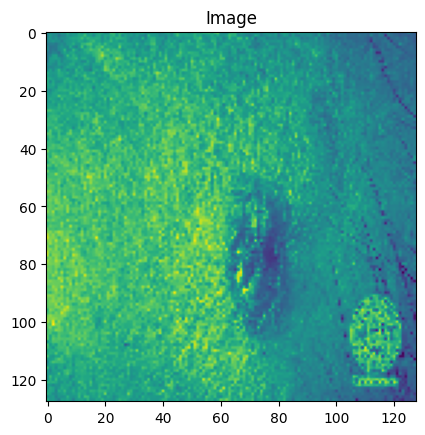

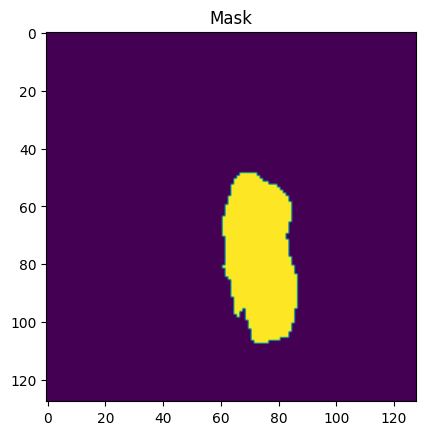

In [7]:
plt.imshow(images[0])
plt.title("Image")
plt.show()

plt.imshow(masks[0])  
plt.title("Mask")
plt.show()

# Métricas de evaluación y entrenamiento (DICE)

In [8]:
# Define loss and performance metrics
# Partially from Abraham and Khan (2019) - A Novel Focal Tversly Loss Function for Lesion Segmentation

# Dice score coefficient and Dice loss 
def dsc(y_true, y_pred):
    smooth = 1.
    # masks
    y_true_fm = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_fm * y_pred_f)
    score = (2. * intersection + smooth) / (K.sum(y_true_fm) + K.sum(y_pred_f) + smooth) 
    return score

def dice_loss(y_true, y_pred):
    loss = 1 - dsc(y_true, y_pred)
    return loss

# Performance metrics: Dice score coefficient, IOU, recall, sensitivity
def auc(y_true, y_pred):
    y_pred_pos = np.round(np.clip(y_pred, 0, 1))
    y_pred_neg = 1 - y_pred_pos
    y_pos = np.round(np.clip(y_true, 0, 1)) # ground truth
    y_neg = 1 - y_pos
    tp = np.sum(y_pos * y_pred_pos)
    tn = np.sum(y_neg * y_pred_neg)
    fp = np.sum(y_neg * y_pred_pos)
    fn = np.sum(y_pos * y_pred_neg)
    tpr = (tp + K.epsilon()) / (tp + fn + K.epsilon()) #recall
    tnr = (tn + K.epsilon()) / (tn + fp + K.epsilon())
    prec = (tp + K.epsilon()) / (tp + fp + K.epsilon()) #precision
    iou = (tp + K.epsilon()) / (tp + fn + fp + K.epsilon()) #intersection over union
    dsc = (2*tp + K.epsilon()) / (2*tp + fn + fp + K.epsilon()) #dice score
    return [dsc, iou, tpr, prec]

## Separación train y test

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)

## Representación de train y validación

In [10]:
def Representacion(history,epochnum, batchnum):
    print('Training time: %s' % (now() - t))

    #Plot the loss and accuracy
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['dsc'] 
    val_acc = history.history['val_dsc']

    epochsn = np.arange(1, len(train_loss)+1,1)
    plt.figure(figsize = (12,5))
    plt.subplot(121)
    plt.plot(epochsn,train_loss, 'b', label='Training Loss')
    plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
    plt.grid(color='gray', linestyle='--')
    plt.legend()
    plt.title('LOSS, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(122)
    plt.plot(epochsn, acc, 'b', label='Training Dice Coefficient')
    plt.plot(epochsn, val_acc, 'r', label='Validation Dice Coefficient')
    plt.grid(color='gray', linestyle='--')
    plt.legend()            
    plt.title('DSC, Epochs={}, Batch={}'.format(epochnum, batchnum))
    plt.xlabel('Epochs')
    plt.ylabel('CSC')
    
    plt.savefig('Graph_UNET.png')
    plt.show()

# U-NET

In [11]:
# Convolutional block for UNet
def ConvBlock(in_fmaps, num_fmaps):
    # Inputs: feature maps for UNet, number of output feature maps
    conv1 = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(in_fmaps)
    conv_out = Conv2D(num_fmaps, (3, 3), activation='relu', padding='same')(conv1)
    return conv_out

In [12]:
# Build the model
def Network():
    
    input = Input(shape=input_size)

    conv1 = ConvBlock(input, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = ConvBlock(pool1, 32)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = ConvBlock(pool2, 64)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = ConvBlock(pool3, 64)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = ConvBlock(pool4, 128)

    up6 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = ConvBlock(up6, 64)

    up7 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = ConvBlock(up7, 64)

    up8 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = ConvBlock(up8, 32)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = ConvBlock(up9, 32)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs = input, outputs = conv10)

    return model

In [13]:
model = Network()
model.compile(optimizer = Adam(learning_rate = 0.0001), loss = dice_loss, metrics = [dsc])

In [ ]:
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

Epoch 1/100
8/8 [==============================] - 12s 1s/step - loss: 0.8355 - dsc: 0.1582 - val_loss: 0.8562 - val_dsc: 0.1431
Epoch 2/100
8/8 [==============================] - 8s 1s/step - loss: 0.8342 - dsc: 0.1683 - val_loss: 0.8545 - val_dsc: 0.1448
Epoch 3/100
8/8 [==============================] - 8s 1s/step - loss: 0.8324 - dsc: 0.1708 - val_loss: 0.8522 - val_dsc: 0.1472
Epoch 4/100
8/8 [==============================] - 9s 1s/step - loss: 0.8300 - dsc: 0.1632 - val_loss: 0.8485 - val_dsc: 0.1509
Epoch 5/100
8/8 [==============================] - 9s 1s/step - loss: 0.8271 - dsc: 0.1839 - val_loss: 0.8420 - val_dsc: 0.1575
Epoch 6/100
8/8 [==============================] - 11s 1s/step - loss: 0.8198 - dsc: 0.1769 - val_loss: 0.8293 - val_dsc: 0.1703
Epoch 7/100
8/8 [==============================] - 10s 1s/step - loss: 0.8070 - dsc: 0.1893 - val_loss: 0.7990 - val_dsc: 0.2009
Epoch 8/100
8/8 [==============================] - 9s 1s/step - loss: 0.7691 - dsc: 0.2305 - val_loss

In [ ]:
# Make predictions
t = now()
preds_UNET = model.predict(X_test)
print('Testing time: %s' % (now() - t))
print(len(X_train[112:140]))

In [ ]:
Representacion(history,epochnum, batchnum)

In [ ]:
train_loss = history.history['loss']
epochsn = np.arange(1, len(train_loss)+1,1)
# Evaluate model
num_test = len(X_test)

# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_UNET.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

In [ ]:
preds_UNET_val = model.predict(X_val)
val_loss = history.history['val_loss']
epochsn = np.arange(1, len(val_loss)+1,1)
# Evaluate model
num_val = len(X_val)

# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_UNET_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_UNET_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_UNET_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC


# U-NET Dense

In [ ]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

In [ ]:
from keras.optimizers import *
from keras.models import *

def DenseUNet(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [ ]:
model = DenseUNet()
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

In [ ]:
# Make predictions
t = now()
preds_Dense = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
Representacion(history,epochnum,batchnum)

In [ ]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Dense[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Dense.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

In [ ]:
preds_Dense_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Dense_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Dense_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Dense_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

# Attention U-NET

In [ ]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)

X_train = tf.convert_to_tensor(X_train)
X_train = tf.reshape(X_train, [X_train.shape[0],X_train.shape[1],X_train.shape[2],1])

X_test = tf.convert_to_tensor(X_test)
X_test = tf.reshape(X_test, [X_test.shape[0],X_test.shape[1],X_test.shape[2],1])

Y_train = tf.convert_to_tensor(Y_train)
Y_train = tf.reshape(Y_train, [Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1])

Y_test = tf.convert_to_tensor(Y_test)
Y_test = tf.reshape(Y_test, [Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1])

X_val = tf.convert_to_tensor(X_val)
X_val = tf.reshape(X_val, [X_val.shape[0],X_val.shape[1],X_val.shape[2],1])

Y_val = tf.convert_to_tensor(Y_val)
Y_val = tf.reshape(Y_val, [Y_val.shape[0],Y_val.shape[1],Y_val.shape[2],1])

In [ ]:
import keras_unet_collection
from keras_unet_collection._model_att_unet_2d import att_unet_2d

model = att_unet_2d(input_size, filter_num=[64, 128, 256, 512, 1024], n_labels=1, 
                           stack_num_down=2, stack_num_up=1, activation='ReLU', 
                           atten_activation='ReLU', attention='add', output_activation='Sigmoid', 
                           batch_norm=True, pool='max', unpool=False,  
                           name='attunet')

In [ ]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=dsc)
import datetime
now = datetime.datetime.now
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

In [ ]:
# Make predictions
t = now()
preds_Att = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
Representacion(history,epochnum,batchnum)

In [ ]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_Att[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_Att.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

In [ ]:
preds_Att_val = model.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_Att_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_Att_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_Att_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC


# U-NET Dense + Attended

In [ ]:
from keras.layers import *

def DenseBlock(channels,inputs):

    conv1_1 = Conv2D(channels, (1, 1),activation=None, padding='same')(inputs)
    conv1_1=BatchActivate(conv1_1)
    conv1_2 = Conv2D(channels//4, (3, 3), activation=None, padding='same')(conv1_1)
    conv1_2 = BatchActivate(conv1_2)

    conv2=concatenate([inputs,conv1_2])
    conv2_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv2)
    conv2_1 = BatchActivate(conv2_1)
    conv2_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv2_1)
    conv2_2 = BatchActivate(conv2_2)

    conv3 = concatenate([inputs, conv1_2,conv2_2])
    conv3_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv3)
    conv3_1 = BatchActivate(conv3_1)
    conv3_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv3_1)
    conv3_2 = BatchActivate(conv3_2)

    conv4 = concatenate([inputs, conv1_2, conv2_2,conv3_2])
    conv4_1 = Conv2D(channels, (1, 1), activation=None, padding='same')(conv4)
    conv4_1 = BatchActivate(conv4_1)
    conv4_2 = Conv2D(channels // 4, (3, 3), activation=None, padding='same')(conv4_1)
    conv4_2 = BatchActivate(conv4_2)
    result=concatenate([inputs,conv1_2, conv2_2,conv3_2,conv4_2])
    return result

def BatchActivate(x):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def Attention_gate(g, s, num_filters):
    Wg = Conv2D(num_filters, 1, padding="same")(g)
    Wg = BatchNormalization()(Wg)
 
    Ws = Conv2D(num_filters, 1, padding="same")(s)
    Ws = BatchNormalization()(Ws)
    
    w = Add()([Wg,Ws])
 
    out = Activation("relu")(w)
    out = Conv2D(num_filters, 1, padding="same")(out)
    out = Activation("sigmoid")(out)
    return Multiply()([out,s])

In [ ]:
from keras.optimizers import *
from keras.models import *

def DenseUNet_AttGate(start_neurons=16, keep_prob=0.9,block_size=7,lr=1e-3):

    inputs = Input(shape=input_size)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation=None, padding="same")(inputs)
    conv1 = BatchActivate(conv1)
    conv1 = DenseBlock(start_neurons * 1, conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = DenseBlock(start_neurons * 2, pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    conv3 = DenseBlock(start_neurons * 4, pool2)
    pool3 = MaxPooling2D((2, 2))(conv3)


    convm = DenseBlock(start_neurons * 8, pool3)


    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(convm)
    Att3 = Attention_gate(conv3,deconv3,start_neurons * 4)  
    uconv3 = concatenate([deconv3, Att3])
    uconv3 = Conv2D(start_neurons * 4, (1, 1), activation=None, padding="same")(uconv3)
    uconv3 = BatchActivate(uconv3)
    uconv3 = DenseBlock(start_neurons * 4, uconv3)


    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    Att2 = Attention_gate(conv2,deconv2,start_neurons * 2)  
    uconv2 = concatenate([deconv2, Att2])
    uconv2 = Conv2D(start_neurons * 2, (1, 1), activation=None, padding="same")(uconv2)
    uconv2 = BatchActivate(uconv2)
    uconv2 = DenseBlock(start_neurons * 2, uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    Att1 = Attention_gate(conv1,deconv1,start_neurons * 1)  
    uconv1 = concatenate([deconv1, Att1])
    uconv1 = Conv2D(start_neurons * 1, (1, 1), activation=None, padding="same")(uconv1)
    uconv1 = BatchActivate(uconv1)
    uconv1 = DenseBlock(start_neurons * 1, uconv1)

    output_layer_noActi = Conv2D(1, (1, 1), padding="same", activation=None)(uconv1)
    output_layer = Activation('sigmoid')(output_layer_noActi)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(optimizer=Adam(lr=1e-3), loss=dice_loss, metrics=[dsc])

    return model

In [ ]:
from sklearn.model_selection import train_test_split
keras.backend.clear_session()
X_train, X_test, Y_train, Y_test = train_test_split(imgs, masks_, test_size=0.3, random_state = 0)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.2, random_state = 0)
model2 = DenseUNet_AttGate()

In [ ]:
t = now()

history = model2.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

In [ ]:
# Make predictions
t = now()
preds_DA = model2.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
Representacion(history,epochnum,batchnum)

In [ ]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_DA[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_DA.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

In [ ]:
preds_DA_val = model2.predict(X_val)
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_DA_val[i,:,:,0] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_DA_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_DA_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

# U-NET 3+

In [ ]:
from keras_unet_collection import models, base, utils
model = models.unet_3plus_2d(input_size, n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=False, name='unet3plus')

In [ ]:
model.compile(loss=dice_loss,optimizer=keras.optimizers.Adam(learning_rate=1e-4), metrics=[dsc]) # lr adaptativo

import datetime
now = datetime.datetime.now
t = now()

history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), batch_size=batchnum, epochs=epochnum, verbose=1)

In [ ]:
# Make predictions
t = now()
preds_3p = model.predict(X_test)
print('Testing time: %s' % (now() - t))

In [ ]:
Representacion(history,epochnum,batchnum)

In [ ]:
# Evaluate model
num_test = len(X_test)
# Calculate performance metrics
dsc_sc = np.zeros((num_test,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_test):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_test[i], preds_3p[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_test,  
        np.sum(iou_sc)/num_test,  
        np.sum(rec_sc)/num_test,
        np.sum(prec_sc)/num_test))
    
# Confusion matrix
confusion = confusion_matrix(Y_test.ravel(),preds_3p.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p.ravel()>thresh, Y_test.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_test
iou_score = np.sum(iou_sc)/num_test
rec_score = np.sum(rec_sc)/num_test
prec_score = np.sum(prec_sc)/num_test
globacc_score = accuracy
auc_roc_score = AUC_ROC

In [ ]:
preds_3p_val = model.predict(X_val)
# Evaluate model
num_val = len(X_val)
# Calculate performance metrics
dsc_sc = np.zeros((num_val,1))
iou_sc = np.zeros_like(dsc_sc)
rec_sc = np.zeros_like(dsc_sc)
tn_sc = np.zeros_like(dsc_sc)
prec_sc = np.zeros_like(dsc_sc)
thresh = 0.5
for i in range(num_val):
    dsc_sc[i], iou_sc[i], rec_sc[i], prec_sc[i] = auc(Y_val[i], preds_3p_val[i] >thresh)
print('-'*30)
print('USING THRESHOLD', thresh)
print('\n DSC \t\t{0:^.3f} \n IOU \t\t{1:^.3f} \n Recall \t{2:^.3f} \n Precision\t{3:^.3f}'.format(
        np.sum(dsc_sc)/num_val,  
        np.sum(iou_sc)/num_val,  
        np.sum(rec_sc)/num_val,
        np.sum(prec_sc)/num_val))
    
# Confusion matrix
confusion = confusion_matrix(Y_val.ravel(),preds_3p_val.ravel()>thresh)
accuracy = 0
if float(np.sum(confusion))!=0:
    accuracy = float(confusion[0,0]+confusion[1,1])/float(np.sum(confusion))
print(' Global Acc \t{0:^.3f}'.format(accuracy))
    
# Area under the ROC curve
AUC_ROC = roc_auc_score(preds_3p_val.ravel()>thresh, Y_val.ravel())
print(' AUC ROC \t{0:^.3f}'.format(AUC_ROC))
print('\n')
print('*'*60)
    
# Save outputs 
numepochs = epochsn[-1]
dice_score = np.sum(dsc_sc)/num_val
iou_score = np.sum(iou_sc)/num_val
rec_score = np.sum(rec_sc)/num_val
prec_score = np.sum(prec_sc)/num_val
globacc_score = accuracy
auc_roc_score = AUC_ROC

# Representación de las mascaras 

In [ ]:
# To plot a set of images with predicted masks uncomment these lines
j = 0
import random
n1 = random.randint(0,len(X_test)-1)
n2 = random.randint(0,len(X_test)-1)
n3 = random.randint(0,len(X_test)-1)
n4 = random.randint(0,len(X_test)-1)
n5 = random.randint(0,len(X_test)-1)
n6 = random.randint(0,len(X_test)-1)
n7 = random.randint(0,len(X_test)-1)
n8 = random.randint(0,len(X_test)-1)
n9 = random.randint(0,len(X_test)-1)
n10 = random.randint(0,len(X_test)-1)

num_disp = [n1,n2,n3,n4,n5,n6,n7,n8,n9,n10]
j=1
plt.figure(figsize = (20,35))
for i in num_disp:
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(X_test[i]), cmap='gray')
    plt.title('Image')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(Y_test[i]),cmap='gray')
    plt.title('Mask')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_UNET[i]),cmap='gray')
    plt.title('UNET')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Dense[i]),cmap='gray')
    plt.title('UNET Dense')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_Att[i]),cmap='gray')
    plt.title('UNET Attended')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_DA[i]),cmap='gray')
    plt.title('UNET Dense + Att')
    j +=1
    plt.subplot(10,7,j)
    plt.imshow(np.squeeze(preds_3p[i]),cmap='gray')
    plt.title('UNET 3+')
    j +=1
    

plt.savefig('Masks.png')
plt.show()